In [1]:
import sys
sys.path.append('../')

In [2]:
from typing import Union, Callable, Optional
import warnings
import torch
import torch.nn.functional as F
import pynndescent
from scipy.spatial import distance


from paradime import relationdata
from paradime import relations
from paradime import transforms
from paradime import dr
from paradime.types import BinaryTensorFun, TensorLike
Transform = Union[transforms.RelationTransform, list[transforms.RelationTransform]]
from paradime import utils

import paradime
from matplotlib import pyplot as plt
import numpy as np

## Test the geodesic dist class

In [3]:
import sklearn.datasets
diabetes = sklearn.datasets.load_diabetes()
data = diabetes['data']

In [4]:
# for isomap
def mse(a, b):
    return torch.sum((a - b) ** 2)


pd_isomap = paradime.dr.ParametricDR(
    model=torch.nn.Linear(10, 2, bias=False),
    global_relations=paradime.relations.GeodesicDist(
        transform=[
            paradime.transforms.ToSquareTensor(),
            paradime.transforms.Functional(lambda x: x.float()),
        ]
    ),
    batch_relations=paradime.relations.DifferentiablePDist(
        transform=paradime.transforms.ToSquareTensor()
    ),
    losses=paradime.loss.RelationLoss(
        loss_function=mse,
        embedding_method="forward",
        normalize_sub=False,
    ),
    verbose=True,
)

pd_isomap.add_training_phase(
    epochs=500,
    batch_size=len(data),
    learning_rate=0.01,
    report_interval=50,
)

pd_isomap.train(data)

2022-12-10 22:06:04,197: Initializing training dataset.
2022-12-10 22:06:04,198: Computing global relations 'rel'.
2022-12-10 22:06:04,199: Calculating pairwise distances.
2022-12-10 22:06:04,288: Beginning training phase 'None'.
2022-12-10 22:06:04,309: Loss after epoch 0: 33007.95703125
2022-12-10 22:06:05,143: Loss after epoch 50: 11349.390625
2022-12-10 22:06:06,050: Loss after epoch 100: 5928.35595703125
2022-12-10 22:06:06,755: Loss after epoch 150: 4992.7392578125
2022-12-10 22:06:07,499: Loss after epoch 200: 4282.30078125
2022-12-10 22:06:08,263: Loss after epoch 250: 3492.2939453125
2022-12-10 22:06:09,043: Loss after epoch 300: 2842.50146484375
2022-12-10 22:06:09,767: Loss after epoch 350: 2462.74658203125
2022-12-10 22:06:10,509: Loss after epoch 400: 2272.177001953125
2022-12-10 22:06:11,218: Loss after epoch 450: 2181.654296875


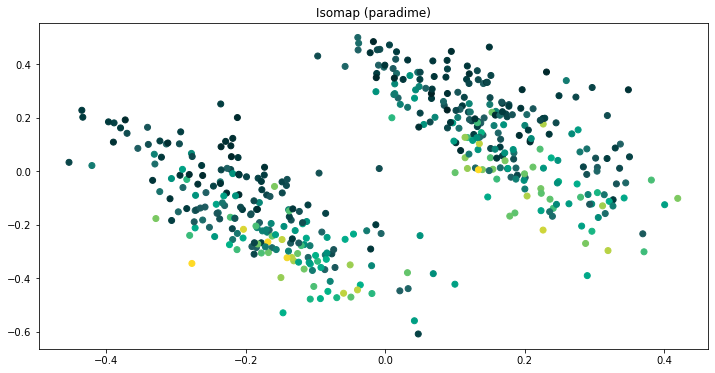

In [9]:
isomap_matrix = pd_isomap.model.weight.detach().numpy()
cmap = paradime.utils.plotting.get_colormap()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(
    *np.stack([np.dot(isomap_matrix, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax.set_title("Isomap (paradime)");

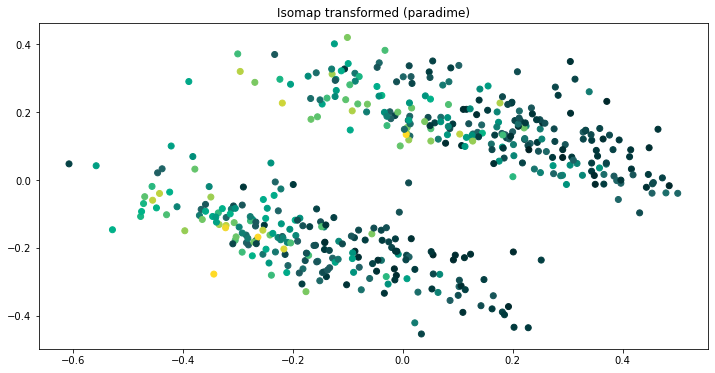

In [6]:
isomap_matrix_tf = isomap_matrix[::-1]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(
    *np.stack([np.dot(isomap_matrix_tf, i) for i in data]).T,
    c=diabetes.target,
    cmap=cmap,
)
ax.set_title("Isomap transformed (paradime)");

## Compare with the Isomap of sklearn

In [7]:
from sklearn.manifold import Isomap
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(data)

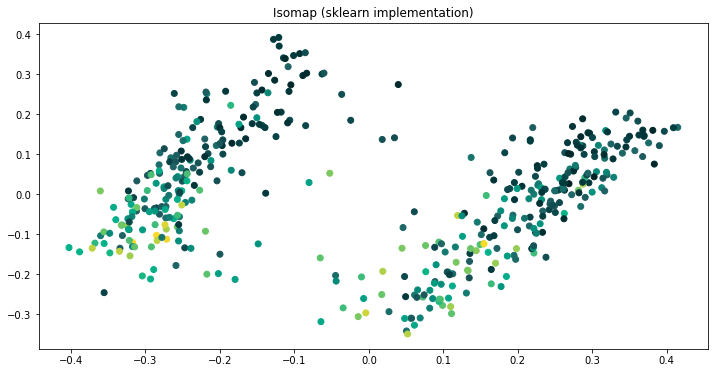

In [10]:
plt.figure(figsize=(12, 6))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=diabetes.target, cmap=paradime.utils.plotting.get_colormap())
plt.title("Isomap (sklearn implementation)")
plt.show()